In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.utils as utils
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
full_df = utils.read_and_concat_csvs_from_dir('/Users/gilmar/gharchive/')
repo_counts = full_df.group_by("repository").len("count").sort("repository")
for repo in repo_counts.to_dicts():
    print(repo["repository"], repo["count"])
repo_df = full_df.filter(pl.col("repository").is_in(["kubernetes", "kubernetes/kubernetes"]))
daily_counts_df = utils.daily_event_count(repo_df)
daily_counts_df

"envoy" 2050
"godot" 6962
"harbor" 420
"home-assistant" 1324
"kubernetes" 37772
"prometheus" 2485
envoyproxy/envoy 143053
goharbor/harbor 16158
home-assistant/core 156857
kubernetes/kubernetes 1366119
prometheus/prometheus 61733


event_date,actor_id,object_id,object_type,daily_event_count
date,str,str,str,u32
2015-08-12,"""101141""","""pr_12608""","""pr""",1
2015-08-12,"""10199099""","""issue_100619930""","""issue""",2
2015-08-12,"""10199099""","""issue_100644251""","""issue""",1
2015-08-12,"""10199099""","""issue_100651217""","""issue""",1
2015-08-12,"""10199099""","""issue_99087702""","""issue""",3
…,…,…,…,…
2021-06-30,"""9950081""","""issue_924763091""","""issue""",1
2021-06-30,"""9950081""","""issue_928613592""","""issue""",1
2021-06-30,"""9950081""","""issue_934187388""","""issue""",1


In [4]:
#daily_counts_df = pl.read_csv("data/godot.csv.gz", 
#        has_header=True,
#        try_parse_dates=True,
#        separator=",",
#        encoding="utf8",)
#daily_counts_df

In [5]:
stats_df = utils.rolling_window_stats(daily_counts_df, event_type="pr").filter(pl.col("rolling_unique_actors").is_not_null())

In [6]:
stats_df = stats_df.with_columns([
    (pl.col("rolling_event_count") / pl.col("rolling_unique_actors")).alias("events_per_actor")
])
stats_df

event_date,rolling_unique_actors,rolling_event_count,events_per_actor
date,u32,u32,f64
2015-09-10,1225,6338,5.173878
2015-09-11,1237,6451,5.215036
2015-09-12,1197,6224,5.199666
2015-09-13,1167,6050,5.184233
2015-09-14,1205,6343,5.2639
…,…,…,…
2021-06-26,905,4771,5.271823
2021-06-27,894,4713,5.271812
2021-06-28,950,5146,5.416842


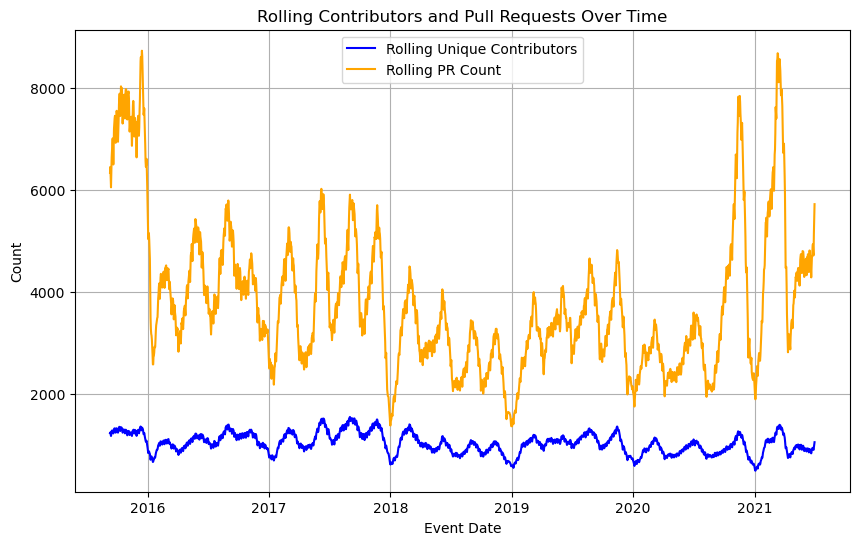

In [15]:
# Plot rolling_unique_actors and rolling_event_count as time series
plt.figure(figsize=(10, 6))
plt.plot(stats_df["event_date"], stats_df["rolling_unique_actors"], label="Rolling Unique Contributors", color="blue")
plt.plot(stats_df["event_date"], stats_df["rolling_event_count"], label="Rolling PR Count", color="orange")
plt.xlabel("Event Date")
plt.ylabel("Count")
plt.title("Rolling Contributors and Pull Requests Over Time")
plt.legend()
plt.grid(True)
plt.show()

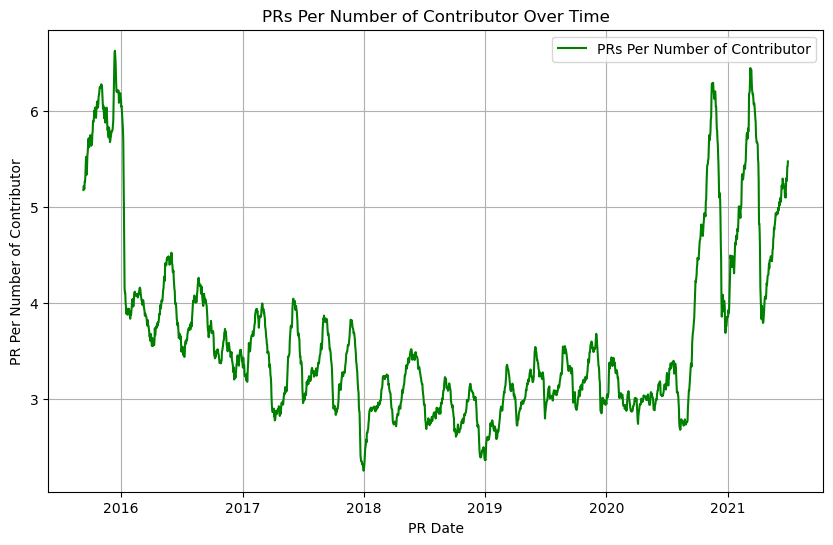

In [8]:
# Plot events_per_actor as a time series
plt.figure(figsize=(10, 6))
plt.plot(stats_df["event_date"], stats_df["events_per_actor"], label="PRs Per Number of Contributor", color="green")
plt.xlabel("PR Date")
plt.ylabel("PR Per Number of Contributor")
plt.title("PRs Per Number of Contributor Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
graph_df = utils.prepare_df_to_graph(daily_counts_df)
graphs_by_date = utils.create_graphs_by_date(graph_df)

# Process the graphs to extract metrics
metrics_df = utils.graphs_metrics_to_dataframe(graphs_by_date, smoothing_period_days=30)
metrics_df

/Users/gilmar/Library/Mobile Documents/com~apple~CloudDocs/learning/master-complex-systems/comp5313/assignments/comp5313-assignment-2/src/utils.py:269: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(


number_of_nodes,number_of_edges,average_clustering,density,average_degree,number_of_isolated_nodes,number_of_connected_components,number_of_supernodes_by_degree,number_of_supernodes_by_betweenness,average_shortest_path_length,diameter,event_date
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
43.0,89.0,0.473324,0.09856,4.139535,0.0,3.0,2.0,1.0,inf,inf,2015-08-12
67.5,153.5,0.489075,0.075319,4.439333,0.0,2.5,2.5,2.0,inf,inf,2015-08-13
71.666667,163.333333,0.52357,0.069517,4.484555,0.0,3.333333,2.666667,2.333333,inf,inf,2015-08-14
60.75,130.0,0.477878,0.071979,3.899131,0.0,4.0,2.25,2.0,inf,inf,2015-08-15
51.6,106.4,0.399191,0.08044,3.439304,0.0,4.0,2.0,2.0,inf,inf,2015-08-16
…,…,…,…,…,…,…,…,…,…,…,…
52.433333,88.033333,0.401523,0.093167,2.989258,0.0,3.1,1.1,0.966667,NaN,NaN,2021-06-26
51.833333,87.4,0.404832,0.096291,2.992086,0.0,3.0,1.1,0.966667,NaN,NaN,2021-06-27
54.4,91.7,0.41422,0.089228,3.040419,0.0,3.0,1.133333,1.0,NaN,NaN,2021-06-28


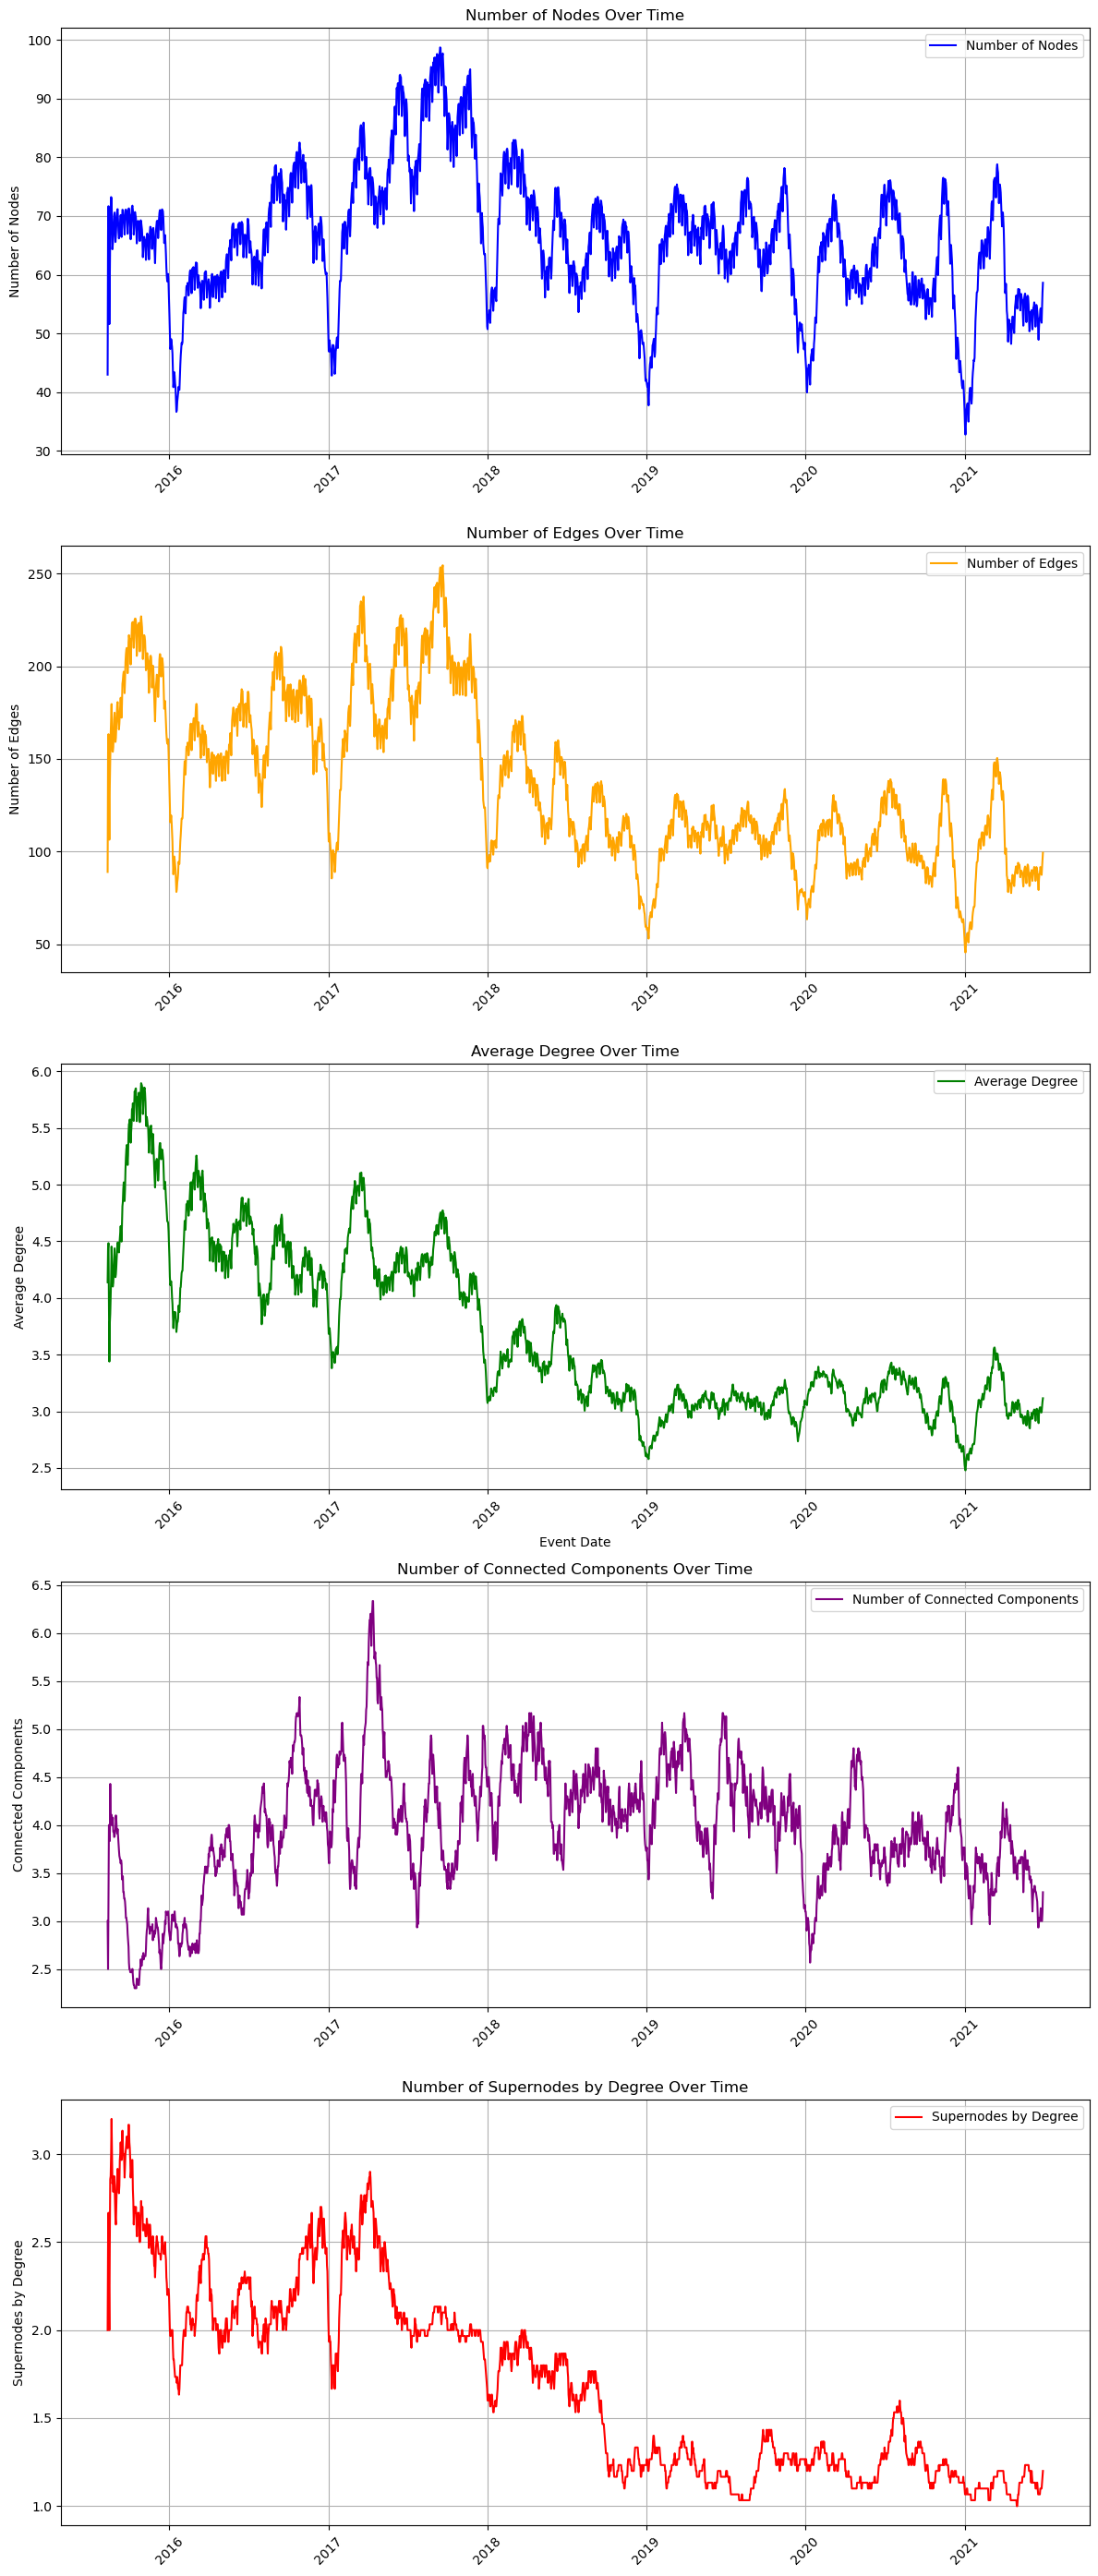

In [12]:
# Convert event_date to datetime format
plot_metrics_df = metrics_df

# Create a figure with subplots (5 rows for 5 metrics)
fig, axes = plt.subplots(5, 1, figsize=(12, 28), sharex=False)

# Plot number_of_nodes
axes[0].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_nodes"], label="Number of Nodes", color="blue")
axes[0].set_ylabel("Number of Nodes")
axes[0].set_title("Number of Nodes Over Time")
axes[0].legend()
axes[0].grid(True)

# Plot number_of_edges
axes[1].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_edges"], label="Number of Edges", color="orange")
axes[1].set_ylabel("Number of Edges")
axes[1].set_title("Number of Edges Over Time")
axes[1].legend()
axes[1].grid(True)

# Plot average_degree
axes[2].plot(plot_metrics_df["event_date"], plot_metrics_df["average_degree"], label="Average Degree", color="green")
axes[2].set_xlabel("Event Date")
axes[2].set_ylabel("Average Degree")
axes[2].set_title("Average Degree Over Time")
axes[2].legend()
axes[2].grid(True)

# Plot number_of_connected_components
axes[3].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_connected_components"], label="Number of Connected Components", color="purple")
axes[3].set_ylabel("Connected Components")
axes[3].set_title("Number of Connected Components Over Time")
axes[3].legend()
axes[3].grid(True)

# Plot number_of_supernodes_by_degree
axes[4].plot(plot_metrics_df["event_date"], plot_metrics_df["number_of_supernodes_by_degree"], label="Supernodes by Degree", color="red")
axes[4].set_ylabel("Supernodes by Degree")
axes[4].set_title("Number of Supernodes by Degree Over Time")
axes[4].legend()
axes[4].grid(True)

# Format x-axis for better readability
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
dcor_events_per_actor_df = utils.distance_correlation_with_column(stats_and_metrics_df, target_col="events_per_actor")
dcor_events_per_actor_df

/Users/gilmar/Library/Mobile Documents/com~apple~CloudDocs/learning/master-complex-systems/comp5313/assignments/comp5313-assignment-2/src/utils.py:413: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return pl.DataFrame(records, schema=["col_x", "col_y", "dcor"])


col_x,col_y,dcor
str,str,f64
"""events_per_actor""","""number_of_nodes""",0.188363
"""events_per_actor""","""number_of_edges""",0.288963
"""events_per_actor""","""density""",0.339485
"""events_per_actor""","""average_degree""",0.400062
"""events_per_actor""","""number_of_connected_components""",0.547454
"""events_per_actor""","""number_of_supernodes_by_degree""",0.29152
"""events_per_actor""","""number_of_supernodes_by_betwee…",0.3655


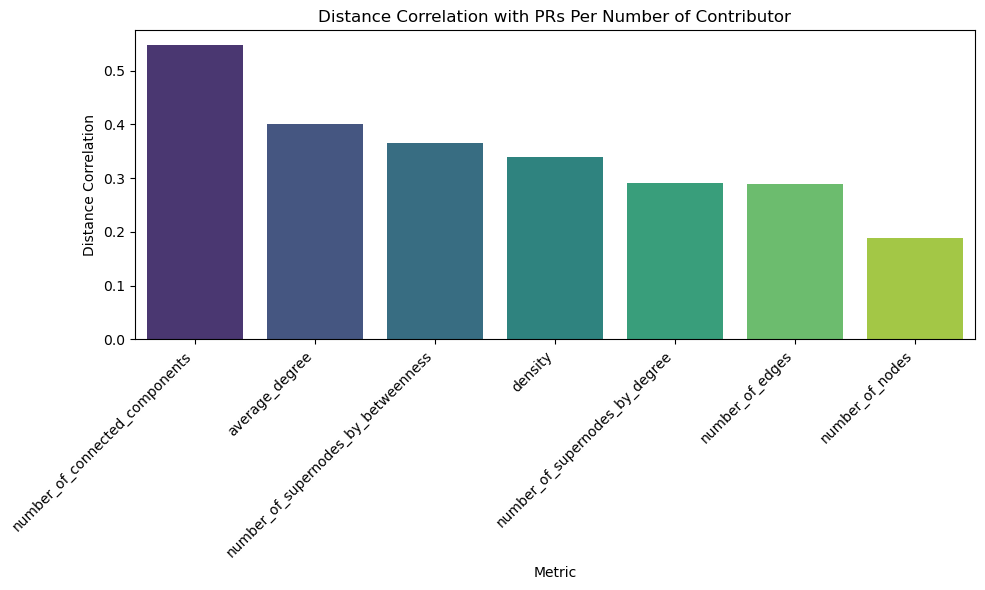

In [14]:
# Sort by dcor and plot
dcor_events_per_actor_df_sorted = dcor_events_per_actor_df.sort("dcor", descending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=dcor_events_per_actor_df_sorted.to_pandas(),
    x="col_y",
    y="dcor",
    hue="col_y",
    palette="viridis",
    legend=False
)
plt.ylabel("Distance Correlation")
plt.xlabel("Metric")
plt.title("Distance Correlation with PRs Per Number of Contributor")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
